In [26]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.utils import resample


In [27]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [29]:
# Set the directory paths
base_dir = './'  # Assuming the current directory contains the 'healthy' and 'unhealthy' folders
healthy_dir = os.path.join(base_dir, 'healthy')
unhealthy_dir = os.path.join(base_dir, 'unhealthy')

# Initialize the data generators
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)  # Using 20% of the data for validation

# Prepare iterators
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Set as training data
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Set as validation data
)


Found 4161 images belonging to 2 classes.
Found 1039 images belonging to 2 classes.


In [30]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
for layer in base_model.layers[:140]:
    layer.trainable = False


In [31]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])


In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [33]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/100
130/130 [==============================] - ETA: 0s - loss: 1.1672 - accuracy: 0.7629 - f1_m: 0.6693 - precision_m: 0.7207 - recall_m: 0.6674
Epoch 1: val_loss improved from inf to 19.67381, saving model to best_model.h5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


130/130 [==============================] - 55s 412ms/step - loss: 1.1672 - accuracy: 0.7629 - f1_m: 0.6693 - precision_m: 0.7207 - recall_m: 0.6674 - val_loss: 19.6738 - val_accuracy: 0.8193 - val_f1_m: 0.7465 - val_precision_m: 0.7820 - val_recall_m: 0.7266
Epoch 2/100
130/130 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.9012 - f1_m: 0.8593 - precision_m: 0.8827 - recall_m: 0.8543
Epoch 2: val_loss improved from 19.67381 to 0.58821, saving model to best_model.h5
130/130 [==============================] - 53s 410ms/step - loss: 0.4993 - accuracy: 0.9012 - f1_m: 0.8593 - precision_m: 0.8827 - recall_m: 0.8543 - val_loss: 0.5882 - val_accuracy: 0.8174 - val_f1_m: 0.7476 - val_precision_m: 0.8042 - val_recall_m: 0.7152
Epoch 3/100
130/130 [==============================] - ETA: 0s - loss: 0.2883 - accuracy: 0.9368 - f1_m: 0.9082 - precision_m: 0.9190 - recall_m: 0.9075
Epoch 3: val_loss did not improve from 0.58821
130/130 [==============================] - 55s 

In [34]:
# Evaluate the model on the validation set
eval_result = model.evaluate(validation_generator)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")


33/33 [==============================] - 6s 168ms/step - loss: 0.5894 - accuracy: 0.8152 - f1_m: 0.7360 - precision_m: 0.7928 - recall_m: 0.7047
Validation Loss: 0.589366614818573, Validation Accuracy: 0.8152069449424744


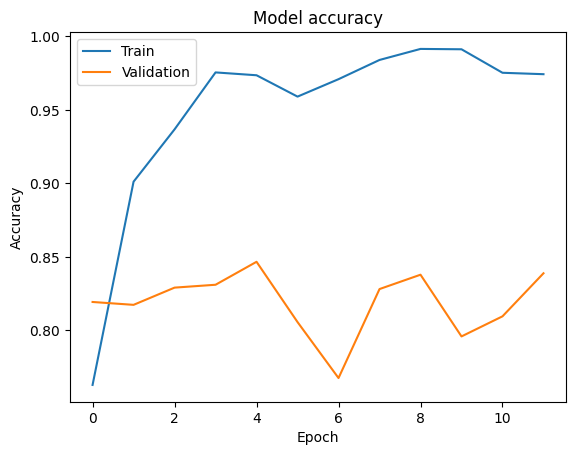

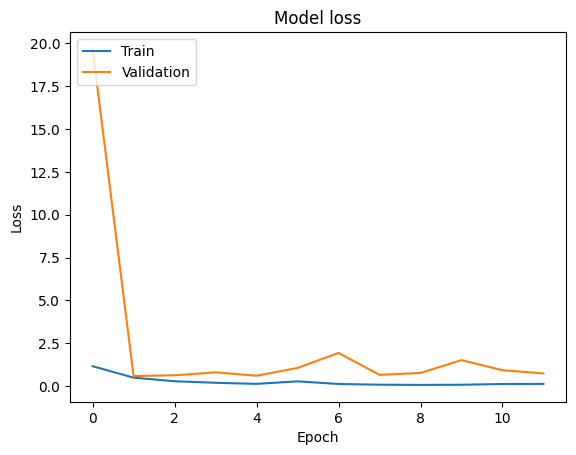

In [35]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [38]:
# Save the model
model.save('SubmissionModel.h5')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
